In [4]:
!python -m pip install traitlets==4.3.3 --force-reinstall
!pip install pywin32==228
!pip install tiktoken
#installing past numpy version
!pip install gensim
!pip install numpy==1.21.6

import torch
import tiktoken
import torch
import torch.nn as nn
import torch.nn.functional as F
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from gensim.models import KeyedVectors

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.__version__)

print(torch.cuda.is_available())

  Using cached traitlets-4.3.3-py2.py3-none-any.whl (75 kB)
  Using cached ipython_genutils-0.2.0-py2.py3-none-any.whl (26 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached decorator-5.1.1-py3-none-any.whl (9.1 kB)
  Attempting uninstall: ipython-genutils
    Found existing installation: ipython-genutils 0.2.0
    Uninstalling ipython-genutils-0.2.0:
      Successfully uninstalled ipython-genutils-0.2.0
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: decorator
    Found existing installation: decorator 4.4.2
    Uninstalling decorator-4.4.2:
      Successfully uninstalled decorator-4.4.2
  Attempting uninstall: traitlets
    Found existing installation: traitlets 5.7.1
    Uninstalling traitlets-5.7.1:
      Successfully uninstalled traitlets-5.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are in

In [5]:
def get_batch(data, seq_len, i):
    """Get a batch of data
    Parameters
    ----------
    data : torch.tensor
        The data to get the batch from
    seq_len : int
        The length of the sequence
    i : int
        The batch index
    Returns
    -------
    torch.tensor
        The input sequence
    torch.tensor
        The target sequence
    """
    seq_len = min(seq_len, len(data) - 1 - i)
    inputs = data[i: i + seq_len]
    targets = data[i + 1: i + 1 + seq_len].reshape(-1)
    return inputs, targets

def get_random_batch(split_type='train', block_size=8, batch_size = 4):
    """Get a random batch of data
    Parameters
    ----------
    split_type : str, optional
        The split to get the batch from, by default 'train'
    block_size : int, optional
        The size of the block (quantity of words per example in the batch), by default 8
    batch_size : int, optional
        The batch size (quantity of examples in the batch), by default 4
    Returns
    -------
    torch.tensor
        The input sequence of size (batch_size, block_size)
    torch.tensor
        The target sequence of size (batch_size, block_size)
    """
    data = train_data if split_type == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])

    x, y = x.to(device), y.to(device)

    return x, y



# TEXT IMPORT (can be changed later on)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
with open('/content/drive/MyDrive/LLM TESTING/NanoGPT/data/don_quixote.txt', "r", encoding = 'utf-8') as f:
    text = f.read()

text= text.replace('\n', ' ').replace('  ', ' ')[121506:]
#text= text.replace(', ', ' , ').replace(': ', ' : ').replace('. ', ' . ').replace('; ', ' ; ').replace('? ', ' ? ').replace('! ', ' ! ')
#text = re.sub(r'(\W|\d)', r' \1 ', text)
text = text.lower()
print(text[:1000])


sed by many more; for if you succeed in this you will have achieved no small success.” in profound silence i listened to what my friend said, and his observations made such an impression on me that, without attempting to question them, i admitted their soundness, and out of them i determined to make this preface; wherein, gentle reader, thou wilt perceive my friend’s good sense, my good fortune in finding such an adviser in such a time of need, and what thou hast gained in receiving, without addition or alteration, the story of the famous don quixote of la mancha, who is held by all the inhabitants of the district of the campo de montiel to have been the chastest lover and the bravest knight that has for many years been seen in that neighbourhood. i have no desire to magnify the service i render thee in making thee acquainted with so renowned and honoured a knight, but i do desire thy thanks for the acquaintance thou wilt make with the famous sancho panza, his squire, in whom, to my th

In [8]:
import re

def split_into_words_special_chars_and_spaces(text):
    return re.findall('\w+|\S|\s', text)

text_separated = split_into_words_special_chars_and_spaces(text)
print(text_separated[:100])

['sed', ' ', 'by', ' ', 'many', ' ', 'more', ';', ' ', 'for', ' ', 'if', ' ', 'you', ' ', 'succeed', ' ', 'in', ' ', 'this', ' ', 'you', ' ', 'will', ' ', 'have', ' ', 'achieved', ' ', 'no', ' ', 'small', ' ', 'success', '.', '”', ' ', 'in', ' ', 'profound', ' ', 'silence', ' ', 'i', ' ', 'listened', ' ', 'to', ' ', 'what', ' ', 'my', ' ', 'friend', ' ', 'said', ',', ' ', 'and', ' ', 'his', ' ', 'observations', ' ', 'made', ' ', 'such', ' ', 'an', ' ', 'impression', ' ', 'on', ' ', 'me', ' ', 'that', ',', ' ', 'without', ' ', 'attempting', ' ', 'to', ' ', 'question', ' ', 'them', ',', ' ', 'i', ' ', 'admitted', ' ', 'their', ' ', 'soundness', ',', ' ', 'and']


In [9]:
vocabulary = list(set(text_separated))
print(vocabulary[0:100])
print("VOC LENGTH: ", len(vocabulary))

['diviners', '84116', 'mischances', 'dozed', 'cupbearer', 'knowest', 'dying', 'communicating', 'souls', 'liege', 'hangers', 'incumbent', 'ávila', 'responded', 'scoldings', 'discloses', 'courtships', 'hard', 'pecked', 'weed', 'victims', 'liquor', '123k', 'erostratus', 'directions', '332k', 'hacked', 'projects', '_sù_', '249k', 'xix', 'bestows', 'fillies', 'instinct', 'principal', 'discarded', 'last', 'scrawl', 'overwhelmed', 'chamber', 'irons', 'verdant', 'dignitary', 'pillaged', 'charles', 'graze', 'unmannerly', 'average', 'thus', 'murdering', 'everlasting', 'killed', 'felled', 'biggest', 'displease', 'crying', 'peerless', '_par', 'firmest', 'pole', 'meant', 'avellaneda', 'seat', 'hassan', 'miracle', 'discord', 'fitter', 'bowshot', 'arch', 'pobre', 'martial', 'incurring', 'wishing', 'absolves', 'mines', 'heaths', 'rubies', 'ignoramus', 'stamps', 'ham', 'itself', 'quinces', 'tunis', 'muttering', 'cancel', 'slacken', 'fulfilling', 'connection', 'noised', 'needles', 'trifle', 'polo', 'per

In [10]:
set(text_separated[:10])

{' ', ';', 'by', 'for', 'many', 'more', 'sed'}

In [11]:
print('Chracters on .txt file: ', len(text))
print('Words on .txt file: ', len(text.split(' ')))


chars = sorted(list(set(text)))
char_vocab_size = len(chars)

words_vocab_size = len(vocabulary)

print('Unique characters: ', char_vocab_size)
print('Unique words: ', words_vocab_size)


Chracters on .txt file:  2190617
Words on .txt file:  410699
Unique characters:  70
Unique words:  15520


# TRAINING DATA PREPARATION

## NORMAL TOKENIZATION

In [12]:
# For now, we will be using a basic encoding using only individual characters

stoi = { ch:i for i,ch in enumerate(vocabulary) }
itos = { i:ch for i,ch in enumerate(vocabulary) }

def encode(text_string):
    sep_text =split_into_words_special_chars_and_spaces(text_string)
    return [stoi[i] for i in sep_text]

def decode(encoded_text_list):
    decoded_text = [itos[i] for i in encoded_text_list]
    return ''.join(decoded_text)


print(encode(text[0:199]))
print(decode(encode(text[0:199])))



[15282, 7334, 1699, 7334, 360, 7334, 1841, 10489, 7334, 11286, 7334, 5517, 7334, 14877, 7334, 12574, 7334, 2084, 7334, 6415, 7334, 14877, 7334, 2213, 7334, 6611, 7334, 11350, 7334, 13164, 7334, 8803, 7334, 521, 7029, 3984, 7334, 2084, 7334, 3888, 7334, 1606, 7334, 10234, 7334, 4898, 7334, 10886, 7334, 8699, 7334, 2797, 7334, 13833, 7334, 9679, 1112, 7334, 5179, 7334, 2737, 7334, 10752, 7334, 6357, 7334, 6720, 7334, 8633, 7334, 15211, 7334, 12152, 7334, 15503, 7334, 14673, 1112, 7334]
sed by many more; for if you succeed in this you will have achieved no small success.” in profound silence i listened to what my friend said, and his observations made such an impression on me that, 


## (NOT WORKING YET) TOKENIZATION: Using TikToken For Tokenization (can be changed later on to other like SentencePiece)
Tiktoken does tokenization per word and special character.

In [13]:
enc = tiktoken.get_encoding('gpt2')

tokenized_text = enc.encode(text)
print(len(tokenized_text))

print(len(text.split(' ')))

token_voc_size = len(list(set(tokenized_text)))
print('UNIQUE TOKENS: ',token_voc_size )

544408
410699
UNIQUE TOKENS:  12714


In [14]:
data = torch.tensor(tokenized_text, dtype=torch.long)

print('Encoded text: ', tokenized_text[:100])
print('Decoded text: ', enc.decode(tokenized_text[:100]))

Encoded text:  [36622, 416, 867, 517, 26, 329, 611, 345, 6758, 287, 428, 345, 481, 423, 8793, 645, 1402, 1943, 13, 447, 251, 287, 11982, 9550, 1312, 16399, 284, 644, 616, 1545, 531, 11, 290, 465, 13050, 925, 884, 281, 10647, 319, 502, 326, 11, 1231, 9361, 284, 1808, 606, 11, 1312, 6848, 511, 2128, 1108, 11, 290, 503, 286, 606, 1312, 5295, 284, 787, 428, 662, 2550, 26, 22881, 11, 10296, 9173, 11, 14210, 266, 2326, 19973, 616, 1545, 447, 247, 82, 922, 2565, 11, 616, 922, 15807, 287, 4917, 884, 281, 12534, 287, 884, 257, 640, 286, 761, 11, 290]
Decoded text:  sed by many more; for if you succeed in this you will have achieved no small success.” in profound silence i listened to what my friend said, and his observations made such an impression on me that, without attempting to question them, i admitted their soundness, and out of them i determined to make this preface; wherein, gentle reader, thou wilt perceive my friend’s good sense, my good fortune in finding such an adviser in such a ti

## (NOT WORKING YET) EMBEDDING: Implementing Word2Vec Embeddings (can be changed later on like GloVe)
In this case, the embedding imported transforms each word and special character into a 300-dim vector, meaning that a sentence of 8 words will be transformed into a [8, 300] tensor.

In [15]:
emb_model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/LLM TESTING/NanoGPT/embedding_models/GoogleNews-vectors-negative300.bin', binary=True)

In [16]:
#using the model to get embeddings of our text
embeddings = []
for word in text.split(' '):
    try:
        embeddings.append(emb_model[word])
    except:
        pass

embeddings = np.array(embeddings)
print(embeddings.shape)

words_vocab_size = len(list(set( text.split(' '))))
print("Unique words (vocab size): ", words_vocab_size)

(294514, 300)
Unique words (vocab size):  29945


In [17]:
#printing an example of the embedding
print('Word: ', text.split(' ')[100])
print('Embedding: ', embeddings[100])

Word:  mancha,
Embedding:  [ 0.0703125   0.08691406  0.08789062  0.0625      0.06933594 -0.10888672
 -0.08154297 -0.15429688  0.02075195  0.13183594 -0.11376953 -0.03735352
  0.06933594  0.078125   -0.10302734 -0.09765625  0.04418945  0.10253906
 -0.06079102 -0.03613281 -0.04541016  0.04736328 -0.12060547 -0.06396484
  0.0022583   0.03710938 -0.00291443  0.11767578  0.06176758  0.06396484
  0.08105469 -0.06884766 -0.0213623   0.05517578 -0.08544922  0.06884766
 -0.12792969 -0.03320312  0.09863281  0.17578125  0.11083984 -0.03466797
 -0.04711914 -0.00848389  0.03588867  0.10302734  0.02697754 -0.02868652
 -0.00512695  0.10644531  0.05981445  0.09423828  0.03369141 -0.02709961
 -0.09423828  0.00102997 -0.04833984  0.03442383  0.08105469 -0.11328125
 -0.08886719  0.03588867 -0.14550781 -0.24414062 -0.06152344  0.05297852
  0.05688477  0.1796875   0.06103516  0.08691406  0.12402344 -0.0402832
  0.02258301  0.17773438 -0.02966309 -0.02966309  0.1171875   0.03112793
 -0.09619141  0.06640625 

Reducing dimensionality...


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7daf72b97520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 847, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 984, in _make_controller_from_path
    lib_controller = controller_class(filepath=filepath, prefix=prefix)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 111, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-742d56dc.3.20.so: cannot open shared object file: No such file or directory


Done!


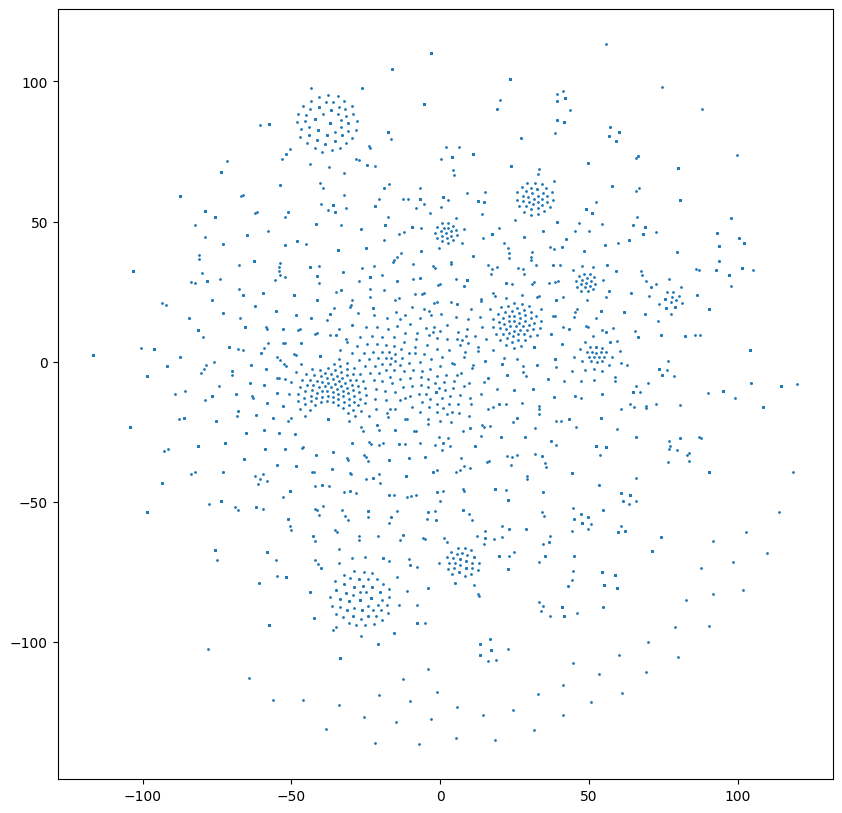

In [18]:
#using TSNE to reduce the dimensionality of the embeddings for just some words
print('Reducing dimensionality...')
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(embeddings[:2500])
print('Done!')

#plotting the embeddings using matplotlib
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=1)
plt.show()

## TRAINING OWN EMBEDDING

In [19]:
import numpy as np
import pandas as pd
import os
import re
import time

from gensim.models import Word2Vec


In [20]:
sentences = []
start = 0
for i, word in enumerate(text_separated):
    if word in [".", '?', '!']:
        sentences.append(text_separated[start : i+1])
        start = i+1


In [21]:
train_emb_sentences =  [item for item in sentences for _ in range(2)]

emb_model = Word2Vec(sentences=sentences,
                 min_count=1,
                 sg=1,
                 vector_size =500,
                 workers=4)


In [22]:
emb_model.wv.most_similar('a')

[('another', 0.6823879480361938),
 ('poor', 0.6515121459960938),
 ('man', 0.6266782283782959),
 ('old', 0.6166909337043762),
 ('an', 0.6100119352340698),
 ('rich', 0.6052917242050171),
 ('some', 0.6019343733787537),
 ('young', 0.6000994443893433),
 ('low', 0.5943751335144043),
 ('dead', 0.5917929410934448)]

# MODEL: Making a Basic Bigram Model
Bigram models are the simplest form of language models that assigns probabilities to word sequences. It is based on the assumption that the probability of a word depends only on the previous word. In other words, it assumes that the probability of a word depends only on the previous word. The probability of a word depends on the previous two words in the case of a trigram model. The probability of a word depends on the previous n words in the case of an n-gram model.

This simple model is just a random model that generates the next character based on the last character (not even the last n-characters). *Tokens DO NOT talk to each other*.

In [23]:
class LayerNorm1d: # (used to be BatchNorm1d)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]


In [24]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_random_batch(split, block_size = block_size, batch_size= batch_size)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear( n_embed, head_size, bias=False)
        self.query = nn.Linear( n_embed, head_size, bias=False)
        self.value = nn.Linear( n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed,  n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        proj = self.proj(out)
        out = self.dropout(proj)
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self,  n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear( n_embed, 4 *  n_embed),
            nn.ReLU(),
            nn.Linear(4 *  n_embed,  n_embed),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Transformer(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self,  n_embed, n_head):
        #  n_embed: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size =  n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward( n_embed)
        self.ln1 = nn.LayerNorm( n_embed)
        self.ln2 = nn.LayerNorm( n_embed)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class BigramModel(nn.Module):

    def __init__(self, char_vocab_size, n_embed):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(char_vocab_size,  n_embed)
        self.position_embedding_table = nn.Embedding(block_size,  n_embed)
        self.blocks = nn.Sequential(*[Transformer( n_embed, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm( n_embed) # final layer norm
        self.lm_head = nn.Linear( n_embed, char_vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,char_vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [25]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_random_batch(split, block_size = block_size, batch_size= batch_size)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear( n_embed, head_size, bias=False)
        self.query = nn.Linear( n_embed, head_size, bias=False)
        self.value = nn.Linear( n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed,  n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        proj = self.proj(out)
        out = self.dropout(proj)
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self,  n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear( n_embed, 4 *  n_embed),
            nn.ReLU(),
            nn.Linear(4 *  n_embed,  n_embed),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Transformer(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self,  n_embed, n_head):
        #  n_embed: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size =  n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward( n_embed)
        self.ln1 = nn.LayerNorm( n_embed)
        self.ln2 = nn.LayerNorm( n_embed)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class BigramModel(nn.Module):

    def __init__(self, char_vocab_size, n_embed):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(char_vocab_size,  n_embed)
        self.position_embedding_table = nn.Embedding(block_size,  n_embed)
        self.blocks = nn.Sequential(*[Transformer( n_embed, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm( n_embed) # final layer norm
        self.lm_head = nn.Linear( n_embed, char_vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,char_vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [26]:
# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embed = 384
n_head = 6
n_layer = 6
dropout = 0.2
# n_embed // n_head must equal batch_size
model = BigramModel(token_voc_size, n_embed) word2vec_model, vocab_size, n_embed):
m = model.to(device)

print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')


optimizer = torch.optim.AdamW(m.parameters(), lr = 1e-3)

for step in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if step % 200 == 0 or step == max_iters - 1:
        losses = estimate_loss()
        print(f"step {step}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    x_train, y_train = get_random_batch('train', block_size = block_size, batch_size= batch_size)
    #print(x_train)
    logits, loss = m(x_train, y_train)
    optimizer.zero_grad(set_to_none = 1)
    loss.backward()
    optimizer.step()


print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long).to(device), max_new_tokens=1000)[0].tolist()))

SyntaxError: ignored

In [ ]:
torch.save(m, 'model.pth')

## EMBEDDING WORD BY WORD TESTING

In [27]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_random_batch(split, block_size = block_size, batch_size= batch_size)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear( n_embed, head_size, bias=False)
        self.query = nn.Linear( n_embed, head_size, bias=False)
        self.value = nn.Linear( n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed,  n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        proj = self.proj(out)
        out = self.dropout(proj)
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self,  n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear( n_embed, 4 *  n_embed),
            nn.ReLU(),
            nn.Linear(4 *  n_embed,  n_embed),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Transformer(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self,  n_embed, n_head):
        #  n_embed: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size =  n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward( n_embed)
        self.ln1 = nn.LayerNorm( n_embed)
        self.ln2 = nn.LayerNorm( n_embed)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class BigramModel(nn.Module):

    def __init__(self, char_vocab_size, n_embed):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(char_vocab_size,  n_embed)
        self.position_embedding_table = nn.Embedding(block_size,  n_embed)
        self.blocks = nn.Sequential(*[Transformer( n_embed, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm( n_embed) # final layer norm
        self.lm_head = nn.Linear( n_embed, char_vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,char_vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [ ]:
# hyperparameters
data  = torch.tensor(encode(text), dtype=torch.long)
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 128 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 20
n_embed = 512
n_head = 32
n_layer = 32
dropout = 0.2
vocab_size = len(vocabulary)
epoch_list = []
train_loss = []
val_loss = []
# n_embed // n_head must equal batch_size

#defining model
import os.path
if os.path.exists('/content/drive/MyDrive/LLM TESTING/NanoGPT/model_backup.pth'):
    model = torch.load('/content/drive/MyDrive/LLM TESTING/NanoGPT/model_backup.pth')
else:
    model = BigramModel(vocab_size, n_embed)
m = model.to(device)
print('Model Defined')

# Setting the training split to 90%
train_split = int(0.9 * len(data))
train_data = data[:train_split]
val_data = data[train_split:]

print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')


optimizer = torch.optim.AdamW(m.parameters(), lr =learning_rate)

for step in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if step % eval_interval == 0 or step == max_iters - 1:
        epoch_list.append(step)
        losses = estimate_loss()
        train_loss.append(losses['train'])
        val_loss.append(losses['val'])
        print(f"step {step}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        torch.save(m, 'model_backup.pth')


    x_train, y_train = get_random_batch('train', block_size = block_size, batch_size= batch_size)
    #print(x_train)
    logits, loss = m(x_train, y_train)
    optimizer.zero_grad(set_to_none = 1)
    loss.backward()
    optimizer.step()

import matplotlib.pyplot as plt
plt.figure()
plt.plot(epoch_list, train_loss)
plt.plot(epoch_list, val_loss)
plt.show()

print(decode(m.generate(idx =torch.zeros((1, 1), dtype=torch.long).to(device), max_new_tokens=1000)[0].tolist()))

Model Defined
116.801696 M parameters
step 0: train loss 9.9520, val loss 9.9426


In [ ]:
torch.save(m, 'model.pth')

In [ ]:
encoded = list(enc.encode('I am Testing this tokenization model.'))
print(encoded)
print([enc.decode([i]) for i in encoded])
print([emb_model[str] for str in [enc.decode([i]) for i in encoded]])

# get wmbeddings of these


In [ ]:
model = Word2Vec(text) #traain using the direct translations from tokenized to list of strings!
model

#NEED TO MAKE EMBEDDINGS FOR EACH TOKENIZATION TRANSLATION (ORIGIN OF ERROR ABOVE)
# 1. separate original string text into sentences
# 2. for each sentence, run tokenization
# 3. for each tokenized sentence, do the same as in print([emb_model[str] for str in [enc.decode([i]) for i in encoded]]) above
# 4. With the list of sentences as [[], [], []], feed into Word2Vec(sentences)
# 5. Save model
# 6. Load as done before in the code and retest cell above

# https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

#OPTION 2: FINETUNE MODEL DOWNLOADED

In [ ]:
len(text_separated)

In [ ]:
encode(text_separated)
